## This notebook is part of self learning Quantum Computing Algorithms

## Solve Stock Portfolio using QAOA 

In [1]:
import numpy as np
from qiskit_finance.data_providers import RandomDataProvider
import datetime
import pandas as pd

In [2]:
num_assets = 4
seed = 123
start=datetime.datetime(2021,6,1)
end=datetime.datetime(2021,6,30)
# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]

In [4]:
length = (end - start).days
generator = np.random.default_rng(123)
data = []
for _ in stocks:
    #row sum(sum revious row value with current and so on...) + add a constant over each row
    d_f = pd.DataFrame(generator.standard_normal(length)).cumsum() + generator.integers(1, 101)
    #pick the maximum value between actual and zero... if value in dataframe is +ve will returned else returned 0
    trimmed = np.maximum(d_f[0].values, np.zeros(len(d_f[0].values)))
    trimmed_list = trimmed.tolist()
    # find index of first 0 element else return -1
    zero_idx = next((idx for idx, val in enumerate(trimmed_list) if val == 0), -1)
    if zero_idx >= 0:
        # set to 0 all values after first 0
        trimmed_list = [val if idx < zero_idx else 0 for idx, val in enumerate(trimmed_list)]
    data.append(trimmed_list)
print(data)

[[16.01087864965215, 15.643091998184266, 16.931017259473514, 17.12499167860613, 18.045222578245983, 18.622326369503234, 17.985862723132257, 18.52781494354255, 18.211219492376735, 17.888830376217772, 17.98599769488823, 16.460067288369277, 17.652233392470936, 16.981143717296828, 17.981413136956288, 18.117734260809407, 19.649767340438203, 18.989797926646382, 18.678003070176462, 19.01577219673529, 16.808301098535484, 17.636222540094224, 19.17785293478484, 20.30465972804987, 21.059429372362118, 20.913451479246895, 22.19535370630661, 23.26938432827855, 23.662005172855824], [62.63823312783908, 61.408000932348635, 62.63423022516978, 60.4621863384846, 60.09203899263228, 60.25641906230695, 61.11630024691969, 62.8779614834315, 63.87128525938331, 63.57976383328487, 64.30789139117401, 63.04629107425432, 64.47622960094303, 64.31975427611363, 63.645995126126564, 63.00693502569436, 62.945573698073986, 62.55278877550404, 64.84269872281862, 64.12451757493803, 64.157125318095, 64.18517521368064, 64.21344

## $\min\limits_{x \in \{0, 1\}^{n}} q \ x^{T}\Sigma x − \mu^{T}x \\ \text{or} \\ \max\limits_{x \in \{0, 1\}^{n}} \mu^{T}x - q \ x^{T}\Sigma x \\ \text{subject to}: 1^{T} x = B$

##### $\text{ref: https://qiskit.org/documentation/tutorials/finance/01_portfolio_optimization.html} \\  x \in \{0, 1\}^{n} \ \text{denotes the vector of binary decision variables, which indicate which assets to pick} \left(x[i]=1\right) \text{and which not to pick} \left(x[i]=0\right), \\ \mu \in R^{n} \ \text{defines the expected returns for the assets}, \\ \Sigma \in R^{n \times n} \text{specifies the covariances between the assets}, \\ q \gt 0 \ \text{controls the risk appetite of the decision maker}, \\ \text{and B denotes the budget, i.e. the number of assets to be selected out of n.}$

## $\text{The equality constraint} \ 1^{T}x = B \ \text{is mapped to a penalty term} \ \left(1^{T} x − B\right)^{2}$

## $\text{Assumptions}:\\ \ \cdot \text{all assets have the same price} \left(\text{normalized to 1}\right) \\ \ \cdot \text{the full budget B has to be spent, i.e., one has to select exactly B assets.}$

In [5]:
def divide_2(val_1, val_2):
    if val_2 == 0:
        if val_1 == 0:
            return 1
        return np.nan
    return val_1 / val_2

## Calculate mean returns 
## $\mu \in R^{n} \ \text{defines the expected returns for the assets}$

In [54]:
#mu = data.get_period_return_mean_vector()

In [6]:
div_func = np.vectorize(divide_2)
period_returns = div_func(np.array(data)[:, 1:], np.array(data)[:, :-1]) - 1
mu = np.mean(period_returns, axis=1)

## Calculate mean covariance
##  $\Sigma \in R^{n \times n} \text{specifies the covariances between the assets}$

In [55]:
#sigma = data.get_period_return_covariance_matrix()

In [7]:
div_func = np.vectorize(divide_2)
period_returns = div_func(np.array(data)[:, 1:], np.array(data)[:, :-1]) - 1
sigma = np.cov(period_returns)

## plot sigma

In [8]:
import matplotlib.pyplot as plt

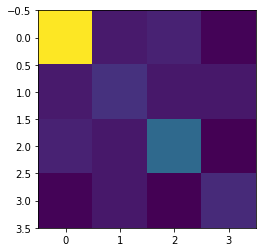

In [9]:
plt.imshow(sigma, interpolation='nearest')
plt.show()

## $q \gt 0 \ \text{controls the risk appetite of the decision maker}$

In [10]:
q = 0.5 # set risk factor

## $\text{B denotes the budget, i.e. the number of assets to be selected out of n.}$

In [11]:
budget = 2 # set budget (B)

### ref: https://qiskit.org/documentation/tutorials/finance/01_portfolio_optimization.html

In [12]:
penalty = num_assets # set parameter to scale the budget penalty term

## Model

In [15]:
from docplex.mp.model import Model

In [16]:
mdl = Model('portfolio model')
#x = mdl.binary_var_list(num_assets)

In [17]:
x = list()
for i in range(num_assets):
    x.append(mdl.binary_var(name="x_{0}".format(i)))
print(x)

[docplex.mp.Var(type=B,name='x_0'), docplex.mp.Var(type=B,name='x_1'), docplex.mp.Var(type=B,name='x_2'), docplex.mp.Var(type=B,name='x_3')]


## $\max\limits_{x \in \{0, 1\}}  \mu^{T} * x - q * x^{T} * \Sigma * x \\ \text{linear} = c^{T}x, \text{qudratic} = x^{T}Qx = \sum\limits_{i, j = 1}^{n} x_{i}^{T} \Sigma_{ij} x_{j} \\ \text{objective} = \text{linear - }\left(\text{risk_factor * qudratic}\right)$

In [18]:
linear = np.dot(mu, x) # mu^T * x
qudratic = mdl.sum([x[i]*sigma[i][j]*x[j] for i in range(num_assets) for j in range(num_assets)])
objective = linear - q * qudratic
mdl.maximize(objective)

## budget constraint:  $\sum\limits_{i =1}^{n} 1^{T}x_{i} == \text{budget}$

In [19]:
cost = mdl.sum([x[i] for i in range(num_assets)])
mdl.add_constraint(cost == budget, ctname='budget')

docplex.mp.LinearConstraint[budget](x_0+x_1+x_2+x_3,EQ,2)

## converting to Quadratic Program

## removing the constraint to create the QUBO

In [22]:
from qiskit_optimization.translators import from_docplex_mp

In [23]:
mod = from_docplex_mp(mdl)

In [24]:
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: portfolio model

Maximize
 obj: 0.015284386652 x_0 - 0.000780952145 x_1 + 0.000517920547 x_2
      + 0.000870005837 x_3 + [ - 0.002541388592 x_0^2 - 0.000146804433 x_0*x_1
      - 0.000257201062 x_0*x_2 + 0.000199722426 x_0*x_3 - 0.000258486713 x_1^2
      - 0.000106085519 x_1*x_2 - 0.000088963242 x_1*x_3 - 0.000791504681 x_2^2
      + 0.000247774763 x_2*x_3 - 0.000197892585 x_3^2 ]/2
Subject To
 budget: x_0 + x_1 + x_2 + x_3 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



## QAOA

In [25]:
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import ADAM, COBYLA
from qiskit import Aer

In [26]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

In [32]:
def print_result(result):
    selection = result.x
    res = list()
    for i in range(len(selection)):
        if selection[i]:
            res.append(stocks[i])
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    print('Optimal: selected stocks {}'.format(res))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(mod).objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [33]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')
cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa_mes)
result = eigen_optimizer.solve(mod)
print_result(result)

Optimal: selection [1. 0. 0. 1.], value 0.0149
Optimal: selected stocks ['TICKER0', 'TICKER3']

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 1 0]	0.0008		0.1710
 [0 1 0 1]	0.0002		0.1707
 [0 0 1 1]	-0.0010		0.1700
 [1 1 0 0]	-0.0130		0.1632
 [1 0 1 0]	-0.0140		0.1627
 [1 0 0 1]	-0.0149		0.1621
 [1 1 1 1]	4.0656		0.0001
 [0 0 0 0]	4.0795		0.0001
 [0 1 0 0]	1.0208		0.0000
 [1 0 1 1]	1.0049		0.0000
 [0 0 1 0]	1.0197		0.0000
 [0 0 0 1]	1.0191		0.0000
 [1 1 0 1]	1.0060		0.0000
 [1 1 1 0]	1.0069		0.0000
 [0 1 1 1]	1.0199		0.0000
 [1 0 0 0]	1.0059		0.0000


## If you have any queries on this notebook please reach to me bala.na@hcl.com